In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/3_Temporal-Difference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# uncomment 2 lines
#!git clone https://github.com/racousin/rl_introduction.git
#from rl_introduction.rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, run_experiment_episode_train

### Run locally

In [3]:
from rl_introduction.tools import Agent, plot_values_lake, policy_evaluation, value_iteration, discount_cumsum, MyRandomAgent, run_experiment_episode_train

# 3_Temporal_Difference

### Objective
Here we present methods to solve the problem of environment and agents when the model is not known.

In [43]:
import numpy as np
import gym
import matplotlib.pyplot as plt
env = gym.make('FrozenLake-v0')

run_experiment_episode_train will be the function used to interact and learn from environment

In [51]:
def run_experiment_episode_train(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset()
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            agent.train(current_state, action, reward, state, done) # agent need a train method
            rews.append(reward)
        rewards[i] = sum(rews)
        print('episode: {} - cum reward {}'.format(i, rewards[i]))
    return rewards

# Usefull tools
Many times, it will be necessary to calculate the discount return $G_t = \sum_{k=0}^T\gamma^k R_{t+k+1}$. For that, we use optimized discount_cumsum function. Example

In [52]:
episode_reward = [0,0,0,1,0,0,0,-.3,0,1,1,0,10]
gamma = 0.9
discount_cumsum(episode_reward, gamma)

array([ 4.14590522,  4.60656136,  5.11840151,  5.68711279,  5.2079031 ,
        5.786559  ,  6.42951   ,  7.1439    ,  8.271     ,  9.19      ,
        9.1       ,  9.        , 10.        ])

In many cases, we will need to compute the disount rewards through multiple episodes:

In [53]:
#TODO: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=500):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(None)#complete here
    return np.hstack(discount_returns)

In [54]:
#Done: compute G along episodes
def get_G(env, gamma=0.99, nb_episode=50):
    discount_returns = []
    for i in range(nb_episode):
        rewards = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            rewards.append(reward)
        discount_returns.append(discount_cumsum(rewards, gamma))
    return np.hstack(discount_returns)

In [55]:
res = get_G(env)
res.shape

(389,)

And to compute the trajectories $(S,A,R,G)_\pi$:

In [56]:
#TODO: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward])) #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(None) # complete here
    return np.vstack(trajectories)

In [57]:
#Done: compute trajectory alon episode
def get_trajectories(env, gamma=0.99, nb_episode=50):
    trajectories = []
    for i in range(nb_episode):
        episode = []
        state = env.reset()
        done = False
        while done is False:
            action = env.action_space.sample()
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))  #S_t, A_t, R_{t+1}
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        trajectories.append(np.c_[discount_return.reshape(-1,1), episode]) #S_t, A_t, R_{t+1}, G_t
    return np.vstack(trajectories)

In [58]:
res = get_trajectories(env)
print(res.shape)
#print('states' : res[:,0])
#print('actions' : res[:,1])
#print('rewards' : res[:,2])
#print('cumulative discounted rewards' : res[:,3])

(376, 4)


# Monte-Carlo Methods

Now, considering an environment without knowing its transition model, we want to build a smart agent, a free model based agent.
The naive approach is to estimate the Q function using monte-carlo estimation.
As we know:
\begin{aligned}
V_{\pi}(s) &= \mathbb{E}[G_t \vert S_t = s] = \frac{1}{P(S_t=s)}E[G_t \mathbb{1}_{S_t=s}] \\
Q_{\pi}(s, a) &= \mathbb{E}_{\pi}[G_t \vert S_t = s, A_t = a]
\end{aligned}
We compute the empirical return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$, following policy $\pi$.
From law of large numbers the estimators:
\begin{aligned}
V_{\pi}(s) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s]}\\
Q(s, a) &\simeq \frac{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a] G_t}{\sum_{t=1}^T \mathbb{1}[S_t = s, A_t = a]}
\end{aligned}

remember Incremental mean:
\begin{aligned}
\mu_K &= \frac{1}{K}\sum_{j=1}^K X_j\\
\mu_K &= \frac{1}{K}[X_K + \sum_{j=1}^{K-1} X_j]\\
\mu_K &= \frac{1}{K}[X_K + (K-1)\mu_{K-1}]\\
\mu_K &= \mu_{K-1} + \frac{1}{K}(X_K -\mu_{K-1})\\
\end{aligned}
As well:
\begin{aligned}
\mu_K &= \mu_{K-p} + \frac{1}{K}(\sum_{K-p}^K X_k - p\mu_{K-p})\\
\end{aligned}
We do the same to update incrementally at each episode the empirical $V$. For each state $S_t$ with return $G_t$:
\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \frac{1}{N_{\text{total}}(S_t)}(G_t - N_{\text{trajectory}}(S_t)V(S_t))\\
\end{aligned}

In [13]:
#TODO: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                Gt_state = discount_return[episode[:,0] == state].sum()
                V[state] += None #complete here
    return V

In [14]:
#Done: complete policy MC evaluation step
def policy_MC_evaluation(env, agent, gamma=1, nb_episode=5000):
    V = np.zeros(env.observation_space.n) 
    N_total = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        episode = []
        N_trajectory = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            episode.append(np.array([current_state, action, reward]))
            N_total[current_state] += 1
            N_trajectory[current_state] += 1
        episode = np.asarray(episode)
        discount_empirical_return = discount_cumsum(episode[:,2], gamma)
        for state, count in enumerate(N_total):
            if count >0 :
                V[state] += (discount_empirical_return[episode[:,0] == state].sum() - N_trajectory[state] * V[state]) / count
    return V

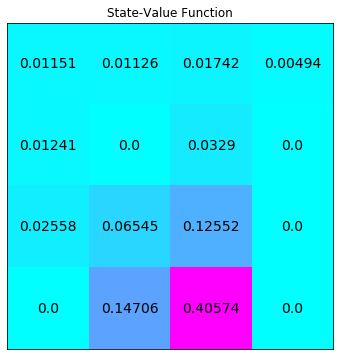

In [63]:
rand_agent = MyRandomAgent(env)
V= policy_MC_evaluation(env, rand_agent)
plot_values_lake(V)

In [64]:
V.sum()

0.8598007038464965

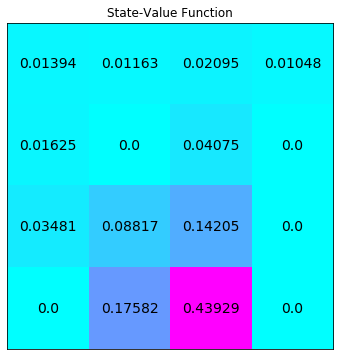

In [60]:
# In reality, here we know the model, we use it to control our results
rand_agent = MyRandomAgent(env)
V = policy_evaluation(env, rand_agent.policy) #see II) dynamic-programming
plot_values_lake(V)

In [61]:
V.sum()

0.9941411498416601

In the same way, we estimate the Q function. 

For Q evaluation
\begin{aligned}
Q(A_t, S_t) &\leftarrow Q(A_t, S_t) + \frac{1}{N_{\text{total}}(A_t, S_t)}(G_t - N_{\text{trajectory}}(A_t, S_t)Q(A_t, S_t))\\
\end{aligned}

And we train an agent, improving its policy by acting greddy.
$\forall s$ $\pi'(.|s) = \arg\max_a Q_\pi(s,a)$.

## Simplest exploration
Without knowing the model, we improve the policy by interacting with the environment. We start with an arbitrary policy, a major problem is caused by a local maximum due to insufficient exploration. To avoid it, we force the agent to act sometimes in a random way (control by an epsilon).

In [73]:
def get_epsilon_greedy_policy(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

In [74]:
class MyMCAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1):
        super().__init__(env, gamma, epsilon)
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n])
        self.count_state_actions = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.episode = []
    def train(self, current_state, action, reward, next_state, done):
        self.episode.append(np.array([current_state, action, reward])) # collect trajectories
        self.count_state_actions[current_state, action] += 1
        self.count_state_actions_by_update[current_state, action] += 1
        if done is True: # we train the agent at every end of episode
            episode = np.asarray(self.episode)
            discount_empirical_return = discount_cumsum(episode[:,2], self.gamma)
            for state in range(len(self.count_state_actions)): # evaluate Q
                for action, count in enumerate(self.count_state_actions[state]):
                    if count > 0 : # evaluate Q
                        self.q[state,action] += (discount_empirical_return[(episode[:,0] == state) & (episode[:,1] == action)].sum() - self.count_state_actions_by_update[state, action] * self.q[state,action]) / count
            self.count_state_actions_by_update = np.zeros((self.env.observation_space.n, self.env.action_space.n))
            self.episode = []
            for state in range(env.observation_space.n): # update policy
                self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 355 - cum reward 0.0
episode: 356 - cum reward 0.0
episode: 357 - cum reward 0.0
episode: 358 - cum reward 0.0
episode: 359 - cum reward 1.0
episode: 360 - cum reward 1.0
episode: 361 - cum reward 1.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 1.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 1.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 1.0
episode: 378 - cum reward 0.0
episode: 379 - cum reward 1.0
episode: 380 - cum reward 0.0
episode: 381 - cum reward 0.0
episode: 382 - cum reward 0.0
episode: 383 - cum reward 1.0
episode: 384 - cum reward 1.0
episode: 385 - cum reward 0.0
episode: 386 - cum reward 1.0
episode: 387 - cum reward 1.0
episode: 3

episode: 640 - cum reward 0.0
episode: 641 - cum reward 0.0
episode: 642 - cum reward 1.0
episode: 643 - cum reward 1.0
episode: 644 - cum reward 1.0
episode: 645 - cum reward 0.0
episode: 646 - cum reward 0.0
episode: 647 - cum reward 0.0
episode: 648 - cum reward 1.0
episode: 649 - cum reward 0.0
episode: 650 - cum reward 0.0
episode: 651 - cum reward 1.0
episode: 652 - cum reward 1.0
episode: 653 - cum reward 0.0
episode: 654 - cum reward 0.0
episode: 655 - cum reward 0.0
episode: 656 - cum reward 1.0
episode: 657 - cum reward 0.0
episode: 658 - cum reward 1.0
episode: 659 - cum reward 0.0
episode: 660 - cum reward 0.0
episode: 661 - cum reward 0.0
episode: 662 - cum reward 1.0
episode: 663 - cum reward 0.0
episode: 664 - cum reward 1.0
episode: 665 - cum reward 1.0
episode: 666 - cum reward 0.0
episode: 667 - cum reward 1.0
episode: 668 - cum reward 1.0
episode: 669 - cum reward 0.0
episode: 670 - cum reward 0.0
episode: 671 - cum reward 0.0
episode: 672 - cum reward 1.0
episode: 6

episode: 932 - cum reward 0.0
episode: 933 - cum reward 0.0
episode: 934 - cum reward 1.0
episode: 935 - cum reward 0.0
episode: 936 - cum reward 1.0
episode: 937 - cum reward 1.0
episode: 938 - cum reward 0.0
episode: 939 - cum reward 0.0
episode: 940 - cum reward 0.0
episode: 941 - cum reward 1.0
episode: 942 - cum reward 1.0
episode: 943 - cum reward 1.0
episode: 944 - cum reward 0.0
episode: 945 - cum reward 1.0
episode: 946 - cum reward 0.0
episode: 947 - cum reward 0.0
episode: 948 - cum reward 1.0
episode: 949 - cum reward 0.0
episode: 950 - cum reward 1.0
episode: 951 - cum reward 1.0
episode: 952 - cum reward 1.0
episode: 953 - cum reward 0.0
episode: 954 - cum reward 1.0
episode: 955 - cum reward 1.0
episode: 956 - cum reward 1.0
episode: 957 - cum reward 0.0
episode: 958 - cum reward 0.0
episode: 959 - cum reward 0.0
episode: 960 - cum reward 0.0
episode: 961 - cum reward 1.0
episode: 962 - cum reward 0.0
episode: 963 - cum reward 1.0
episode: 964 - cum reward 1.0
episode: 9

episode: 1204 - cum reward 1.0
episode: 1205 - cum reward 0.0
episode: 1206 - cum reward 1.0
episode: 1207 - cum reward 0.0
episode: 1208 - cum reward 1.0
episode: 1209 - cum reward 0.0
episode: 1210 - cum reward 0.0
episode: 1211 - cum reward 0.0
episode: 1212 - cum reward 0.0
episode: 1213 - cum reward 1.0
episode: 1214 - cum reward 1.0
episode: 1215 - cum reward 0.0
episode: 1216 - cum reward 0.0
episode: 1217 - cum reward 0.0
episode: 1218 - cum reward 0.0
episode: 1219 - cum reward 1.0
episode: 1220 - cum reward 1.0
episode: 1221 - cum reward 1.0
episode: 1222 - cum reward 0.0
episode: 1223 - cum reward 1.0
episode: 1224 - cum reward 0.0
episode: 1225 - cum reward 0.0
episode: 1226 - cum reward 1.0
episode: 1227 - cum reward 1.0
episode: 1228 - cum reward 1.0
episode: 1229 - cum reward 1.0
episode: 1230 - cum reward 0.0
episode: 1231 - cum reward 0.0
episode: 1232 - cum reward 0.0
episode: 1233 - cum reward 1.0
episode: 1234 - cum reward 0.0
episode: 1235 - cum reward 1.0
episode:

episode: 1501 - cum reward 0.0
episode: 1502 - cum reward 1.0
episode: 1503 - cum reward 0.0
episode: 1504 - cum reward 0.0
episode: 1505 - cum reward 0.0
episode: 1506 - cum reward 1.0
episode: 1507 - cum reward 0.0
episode: 1508 - cum reward 0.0
episode: 1509 - cum reward 1.0
episode: 1510 - cum reward 0.0
episode: 1511 - cum reward 1.0
episode: 1512 - cum reward 0.0
episode: 1513 - cum reward 0.0
episode: 1514 - cum reward 1.0
episode: 1515 - cum reward 1.0
episode: 1516 - cum reward 0.0
episode: 1517 - cum reward 0.0
episode: 1518 - cum reward 0.0
episode: 1519 - cum reward 1.0
episode: 1520 - cum reward 0.0
episode: 1521 - cum reward 1.0
episode: 1522 - cum reward 1.0
episode: 1523 - cum reward 1.0
episode: 1524 - cum reward 1.0
episode: 1525 - cum reward 1.0
episode: 1526 - cum reward 0.0
episode: 1527 - cum reward 1.0
episode: 1528 - cum reward 0.0
episode: 1529 - cum reward 1.0
episode: 1530 - cum reward 0.0
episode: 1531 - cum reward 0.0
episode: 1532 - cum reward 1.0
episode:

episode: 1790 - cum reward 1.0
episode: 1791 - cum reward 1.0
episode: 1792 - cum reward 1.0
episode: 1793 - cum reward 1.0
episode: 1794 - cum reward 0.0
episode: 1795 - cum reward 0.0
episode: 1796 - cum reward 0.0
episode: 1797 - cum reward 1.0
episode: 1798 - cum reward 0.0
episode: 1799 - cum reward 1.0
episode: 1800 - cum reward 0.0
episode: 1801 - cum reward 1.0
episode: 1802 - cum reward 0.0
episode: 1803 - cum reward 1.0
episode: 1804 - cum reward 0.0
episode: 1805 - cum reward 0.0
episode: 1806 - cum reward 1.0
episode: 1807 - cum reward 1.0
episode: 1808 - cum reward 1.0
episode: 1809 - cum reward 1.0
episode: 1810 - cum reward 0.0
episode: 1811 - cum reward 1.0
episode: 1812 - cum reward 0.0
episode: 1813 - cum reward 1.0
episode: 1814 - cum reward 0.0
episode: 1815 - cum reward 1.0
episode: 1816 - cum reward 1.0
episode: 1817 - cum reward 1.0
episode: 1818 - cum reward 0.0
episode: 1819 - cum reward 1.0
episode: 1820 - cum reward 1.0
episode: 1821 - cum reward 0.0
episode:

episode: 2092 - cum reward 1.0
episode: 2093 - cum reward 1.0
episode: 2094 - cum reward 1.0
episode: 2095 - cum reward 0.0
episode: 2096 - cum reward 0.0
episode: 2097 - cum reward 1.0
episode: 2098 - cum reward 1.0
episode: 2099 - cum reward 0.0
episode: 2100 - cum reward 1.0
episode: 2101 - cum reward 1.0
episode: 2102 - cum reward 1.0
episode: 2103 - cum reward 1.0
episode: 2104 - cum reward 1.0
episode: 2105 - cum reward 1.0
episode: 2106 - cum reward 0.0
episode: 2107 - cum reward 0.0
episode: 2108 - cum reward 0.0
episode: 2109 - cum reward 0.0
episode: 2110 - cum reward 1.0
episode: 2111 - cum reward 1.0
episode: 2112 - cum reward 0.0
episode: 2113 - cum reward 1.0
episode: 2114 - cum reward 0.0
episode: 2115 - cum reward 1.0
episode: 2116 - cum reward 1.0
episode: 2117 - cum reward 1.0
episode: 2118 - cum reward 1.0
episode: 2119 - cum reward 0.0
episode: 2120 - cum reward 0.0
episode: 2121 - cum reward 0.0
episode: 2122 - cum reward 1.0
episode: 2123 - cum reward 0.0
episode:

episode: 2378 - cum reward 1.0
episode: 2379 - cum reward 1.0
episode: 2380 - cum reward 1.0
episode: 2381 - cum reward 1.0
episode: 2382 - cum reward 1.0
episode: 2383 - cum reward 0.0
episode: 2384 - cum reward 1.0
episode: 2385 - cum reward 0.0
episode: 2386 - cum reward 1.0
episode: 2387 - cum reward 1.0
episode: 2388 - cum reward 0.0
episode: 2389 - cum reward 0.0
episode: 2390 - cum reward 0.0
episode: 2391 - cum reward 1.0
episode: 2392 - cum reward 1.0
episode: 2393 - cum reward 1.0
episode: 2394 - cum reward 0.0
episode: 2395 - cum reward 1.0
episode: 2396 - cum reward 1.0
episode: 2397 - cum reward 0.0
episode: 2398 - cum reward 0.0
episode: 2399 - cum reward 0.0
episode: 2400 - cum reward 0.0
episode: 2401 - cum reward 0.0
episode: 2402 - cum reward 1.0
episode: 2403 - cum reward 0.0
episode: 2404 - cum reward 0.0
episode: 2405 - cum reward 0.0
episode: 2406 - cum reward 0.0
episode: 2407 - cum reward 1.0
episode: 2408 - cum reward 0.0
episode: 2409 - cum reward 1.0
episode:

episode: 2651 - cum reward 1.0
episode: 2652 - cum reward 0.0
episode: 2653 - cum reward 1.0
episode: 2654 - cum reward 0.0
episode: 2655 - cum reward 1.0
episode: 2656 - cum reward 1.0
episode: 2657 - cum reward 0.0
episode: 2658 - cum reward 1.0
episode: 2659 - cum reward 0.0
episode: 2660 - cum reward 1.0
episode: 2661 - cum reward 1.0
episode: 2662 - cum reward 1.0
episode: 2663 - cum reward 0.0
episode: 2664 - cum reward 1.0
episode: 2665 - cum reward 0.0
episode: 2666 - cum reward 1.0
episode: 2667 - cum reward 0.0
episode: 2668 - cum reward 1.0
episode: 2669 - cum reward 0.0
episode: 2670 - cum reward 0.0
episode: 2671 - cum reward 0.0
episode: 2672 - cum reward 0.0
episode: 2673 - cum reward 1.0
episode: 2674 - cum reward 0.0
episode: 2675 - cum reward 1.0
episode: 2676 - cum reward 0.0
episode: 2677 - cum reward 0.0
episode: 2678 - cum reward 0.0
episode: 2679 - cum reward 1.0
episode: 2680 - cum reward 0.0
episode: 2681 - cum reward 1.0
episode: 2682 - cum reward 1.0
episode:

episode: 2922 - cum reward 1.0
episode: 2923 - cum reward 0.0
episode: 2924 - cum reward 1.0
episode: 2925 - cum reward 0.0
episode: 2926 - cum reward 1.0
episode: 2927 - cum reward 1.0
episode: 2928 - cum reward 0.0
episode: 2929 - cum reward 1.0
episode: 2930 - cum reward 1.0
episode: 2931 - cum reward 0.0
episode: 2932 - cum reward 1.0
episode: 2933 - cum reward 0.0
episode: 2934 - cum reward 0.0
episode: 2935 - cum reward 0.0
episode: 2936 - cum reward 0.0
episode: 2937 - cum reward 0.0
episode: 2938 - cum reward 0.0
episode: 2939 - cum reward 1.0
episode: 2940 - cum reward 0.0
episode: 2941 - cum reward 0.0
episode: 2942 - cum reward 0.0
episode: 2943 - cum reward 0.0
episode: 2944 - cum reward 0.0
episode: 2945 - cum reward 0.0
episode: 2946 - cum reward 0.0
episode: 2947 - cum reward 0.0
episode: 2948 - cum reward 1.0
episode: 2949 - cum reward 0.0
episode: 2950 - cum reward 1.0
episode: 2951 - cum reward 1.0
episode: 2952 - cum reward 0.0
episode: 2953 - cum reward 0.0
episode:

episode: 3194 - cum reward 0.0
episode: 3195 - cum reward 1.0
episode: 3196 - cum reward 0.0
episode: 3197 - cum reward 1.0
episode: 3198 - cum reward 1.0
episode: 3199 - cum reward 0.0
episode: 3200 - cum reward 0.0
episode: 3201 - cum reward 1.0
episode: 3202 - cum reward 0.0
episode: 3203 - cum reward 1.0
episode: 3204 - cum reward 1.0
episode: 3205 - cum reward 0.0
episode: 3206 - cum reward 0.0
episode: 3207 - cum reward 0.0
episode: 3208 - cum reward 0.0
episode: 3209 - cum reward 1.0
episode: 3210 - cum reward 0.0
episode: 3211 - cum reward 1.0
episode: 3212 - cum reward 1.0
episode: 3213 - cum reward 0.0
episode: 3214 - cum reward 0.0
episode: 3215 - cum reward 1.0
episode: 3216 - cum reward 1.0
episode: 3217 - cum reward 1.0
episode: 3218 - cum reward 0.0
episode: 3219 - cum reward 0.0
episode: 3220 - cum reward 1.0
episode: 3221 - cum reward 1.0
episode: 3222 - cum reward 1.0
episode: 3223 - cum reward 1.0
episode: 3224 - cum reward 0.0
episode: 3225 - cum reward 0.0
episode:

episode: 3485 - cum reward 1.0
episode: 3486 - cum reward 0.0
episode: 3487 - cum reward 1.0
episode: 3488 - cum reward 0.0
episode: 3489 - cum reward 1.0
episode: 3490 - cum reward 0.0
episode: 3491 - cum reward 0.0
episode: 3492 - cum reward 0.0
episode: 3493 - cum reward 1.0
episode: 3494 - cum reward 0.0
episode: 3495 - cum reward 0.0
episode: 3496 - cum reward 0.0
episode: 3497 - cum reward 0.0
episode: 3498 - cum reward 0.0
episode: 3499 - cum reward 0.0
episode: 3500 - cum reward 0.0
episode: 3501 - cum reward 1.0
episode: 3502 - cum reward 1.0
episode: 3503 - cum reward 0.0
episode: 3504 - cum reward 0.0
episode: 3505 - cum reward 1.0
episode: 3506 - cum reward 1.0
episode: 3507 - cum reward 1.0
episode: 3508 - cum reward 0.0
episode: 3509 - cum reward 0.0
episode: 3510 - cum reward 1.0
episode: 3511 - cum reward 0.0
episode: 3512 - cum reward 0.0
episode: 3513 - cum reward 1.0
episode: 3514 - cum reward 0.0
episode: 3515 - cum reward 0.0
episode: 3516 - cum reward 0.0
episode:

episode: 3768 - cum reward 1.0
episode: 3769 - cum reward 0.0
episode: 3770 - cum reward 1.0
episode: 3771 - cum reward 0.0
episode: 3772 - cum reward 1.0
episode: 3773 - cum reward 0.0
episode: 3774 - cum reward 1.0
episode: 3775 - cum reward 1.0
episode: 3776 - cum reward 1.0
episode: 3777 - cum reward 1.0
episode: 3778 - cum reward 1.0
episode: 3779 - cum reward 0.0
episode: 3780 - cum reward 0.0
episode: 3781 - cum reward 0.0
episode: 3782 - cum reward 1.0
episode: 3783 - cum reward 0.0
episode: 3784 - cum reward 1.0
episode: 3785 - cum reward 1.0
episode: 3786 - cum reward 0.0
episode: 3787 - cum reward 0.0
episode: 3788 - cum reward 1.0
episode: 3789 - cum reward 0.0
episode: 3790 - cum reward 0.0
episode: 3791 - cum reward 1.0
episode: 3792 - cum reward 0.0
episode: 3793 - cum reward 1.0
episode: 3794 - cum reward 0.0
episode: 3795 - cum reward 1.0
episode: 3796 - cum reward 0.0
episode: 3797 - cum reward 0.0
episode: 3798 - cum reward 1.0
episode: 3799 - cum reward 0.0
episode:

episode: 4056 - cum reward 1.0
episode: 4057 - cum reward 1.0
episode: 4058 - cum reward 1.0
episode: 4059 - cum reward 0.0
episode: 4060 - cum reward 0.0
episode: 4061 - cum reward 1.0
episode: 4062 - cum reward 0.0
episode: 4063 - cum reward 0.0
episode: 4064 - cum reward 1.0
episode: 4065 - cum reward 1.0
episode: 4066 - cum reward 1.0
episode: 4067 - cum reward 0.0
episode: 4068 - cum reward 1.0
episode: 4069 - cum reward 0.0
episode: 4070 - cum reward 0.0
episode: 4071 - cum reward 0.0
episode: 4072 - cum reward 1.0
episode: 4073 - cum reward 0.0
episode: 4074 - cum reward 1.0
episode: 4075 - cum reward 1.0
episode: 4076 - cum reward 0.0
episode: 4077 - cum reward 0.0
episode: 4078 - cum reward 0.0
episode: 4079 - cum reward 1.0
episode: 4080 - cum reward 0.0
episode: 4081 - cum reward 1.0
episode: 4082 - cum reward 0.0
episode: 4083 - cum reward 0.0
episode: 4084 - cum reward 0.0
episode: 4085 - cum reward 0.0
episode: 4086 - cum reward 0.0
episode: 4087 - cum reward 0.0
episode:

episode: 4352 - cum reward 0.0
episode: 4353 - cum reward 1.0
episode: 4354 - cum reward 1.0
episode: 4355 - cum reward 0.0
episode: 4356 - cum reward 0.0
episode: 4357 - cum reward 0.0
episode: 4358 - cum reward 0.0
episode: 4359 - cum reward 0.0
episode: 4360 - cum reward 1.0
episode: 4361 - cum reward 1.0
episode: 4362 - cum reward 1.0
episode: 4363 - cum reward 0.0
episode: 4364 - cum reward 1.0
episode: 4365 - cum reward 0.0
episode: 4366 - cum reward 1.0
episode: 4367 - cum reward 0.0
episode: 4368 - cum reward 1.0
episode: 4369 - cum reward 0.0
episode: 4370 - cum reward 0.0
episode: 4371 - cum reward 0.0
episode: 4372 - cum reward 0.0
episode: 4373 - cum reward 0.0
episode: 4374 - cum reward 1.0
episode: 4375 - cum reward 1.0
episode: 4376 - cum reward 0.0
episode: 4377 - cum reward 0.0
episode: 4378 - cum reward 0.0
episode: 4379 - cum reward 0.0
episode: 4380 - cum reward 0.0
episode: 4381 - cum reward 1.0
episode: 4382 - cum reward 1.0
episode: 4383 - cum reward 1.0
episode:

episode: 4644 - cum reward 0.0
episode: 4645 - cum reward 1.0
episode: 4646 - cum reward 1.0
episode: 4647 - cum reward 1.0
episode: 4648 - cum reward 1.0
episode: 4649 - cum reward 0.0
episode: 4650 - cum reward 0.0
episode: 4651 - cum reward 1.0
episode: 4652 - cum reward 0.0
episode: 4653 - cum reward 1.0
episode: 4654 - cum reward 1.0
episode: 4655 - cum reward 0.0
episode: 4656 - cum reward 1.0
episode: 4657 - cum reward 0.0
episode: 4658 - cum reward 0.0
episode: 4659 - cum reward 1.0
episode: 4660 - cum reward 1.0
episode: 4661 - cum reward 1.0
episode: 4662 - cum reward 0.0
episode: 4663 - cum reward 0.0
episode: 4664 - cum reward 0.0
episode: 4665 - cum reward 0.0
episode: 4666 - cum reward 0.0
episode: 4667 - cum reward 1.0
episode: 4668 - cum reward 1.0
episode: 4669 - cum reward 0.0
episode: 4670 - cum reward 1.0
episode: 4671 - cum reward 0.0
episode: 4672 - cum reward 0.0
episode: 4673 - cum reward 1.0
episode: 4674 - cum reward 0.0
episode: 4675 - cum reward 0.0
episode:

episode: 4953 - cum reward 1.0
episode: 4954 - cum reward 0.0
episode: 4955 - cum reward 0.0
episode: 4956 - cum reward 1.0
episode: 4957 - cum reward 1.0
episode: 4958 - cum reward 1.0
episode: 4959 - cum reward 1.0
episode: 4960 - cum reward 1.0
episode: 4961 - cum reward 1.0
episode: 4962 - cum reward 0.0
episode: 4963 - cum reward 1.0
episode: 4964 - cum reward 1.0
episode: 4965 - cum reward 0.0
episode: 4966 - cum reward 0.0
episode: 4967 - cum reward 0.0
episode: 4968 - cum reward 1.0
episode: 4969 - cum reward 0.0
episode: 4970 - cum reward 0.0
episode: 4971 - cum reward 0.0
episode: 4972 - cum reward 1.0
episode: 4973 - cum reward 1.0
episode: 4974 - cum reward 0.0
episode: 4975 - cum reward 1.0
episode: 4976 - cum reward 0.0
episode: 4977 - cum reward 1.0
episode: 4978 - cum reward 0.0
episode: 4979 - cum reward 0.0
episode: 4980 - cum reward 1.0
episode: 4981 - cum reward 1.0
episode: 4982 - cum reward 1.0
episode: 4983 - cum reward 1.0
episode: 4984 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - mc_agent')

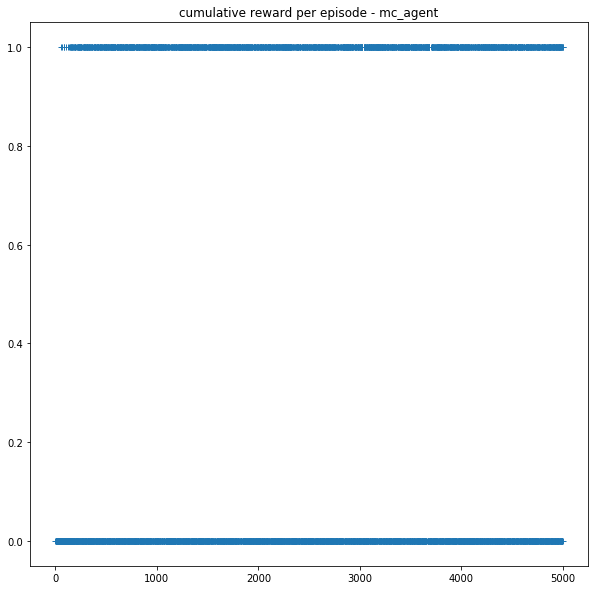

In [75]:
mc_agent = MyMCAgent(env)
rewards = run_experiment_episode_train(env, mc_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - mc_agent')

In [76]:
mc_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

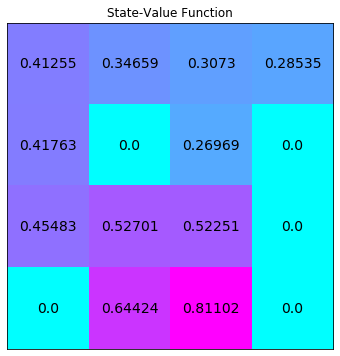

In [77]:
V = policy_evaluation(env, mc_agent.policy)
plot_values_lake(V)

In [78]:
V.sum()

4.9987123090444285

# Temporal-Difference-Learning (Monte-Carlo bootstrap) 

Using monte-carlo, we update $V(S_t)$ in that way

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_t)) \\
\end{aligned}
Using bellman equation $\mathbb{E}[G_t|S_t=s] = \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})|S_t=s]$, That pushes new estimators/update

TD target $= R_{t+1} + \gamma V(S_{t+1}$)

TD error $=$ target $- V(S_t)$

update:  

\begin{aligned}
V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}

In [80]:
#TODO: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += None #complete here
    return V

In [81]:
#Done: complete policy td evaluation step
def policy_td_evaluation(env, agent, gamma=1, nb_episode=5000, alpha = .01):
    V = np.zeros(env.observation_space.n)
    for i in range(nb_episode):
        count_states = np.zeros(env.observation_space.n)
        state = env.reset()
        done = False
        while done is False:
            action = agent.act(state)
            current_state = state
            state, reward, done, info = env.step(action)
            target = reward + gamma * V[state]
            td_error = target - V[current_state]
            count_states[current_state] += 1
            V[current_state] += td_error * alpha
    return V

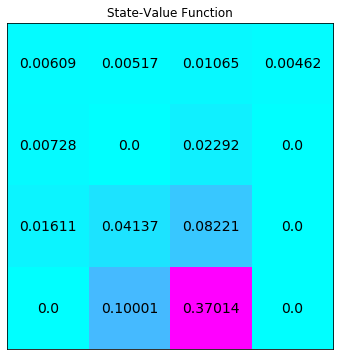

In [82]:
rand_agent = MyRandomAgent(env)
V = policy_td_evaluation(env, rand_agent)
plot_values_lake(V)

### SARSA

Same principle for q function update using Temporal difference$Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$.

In [88]:
class MySarsaAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
        self.sarsa = [None, None, None, None, None] #[s,a,r,s,a]
        self.tmp_reward = None
    def qsa_update(self, done):
        if done:
            target = self.sarsa[2]
        else:
            target = self.sarsa[2] + self.gamma * self.q[self.sarsa[-2], self.sarsa[-1]] 
        td_error = target - self.q[self.sarsa[0], self.sarsa[1]]
        self.q[self.sarsa[0], self.sarsa[1]]  += self.alpha * td_error
        
    def train(self, current_state, action, reward, next_state, done):
        self.sarsa[0] = self.sarsa[-2]
        self.sarsa[1] = self.sarsa[-1]
        self.sarsa[2] = self.tmp_reward
        self.sarsa[3] = current_state
        self.sarsa[4] = action
        self.tmp_reward = reward
        if self.sarsa[0] is None:
            pass
        else:
            self.qsa_update(done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 0.0
episode: 6 - cum reward 0.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 1.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 0.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 0.0
episode: 34 - cum reward

episode: 359 - cum reward 0.0
episode: 360 - cum reward 0.0
episode: 361 - cum reward 0.0
episode: 362 - cum reward 0.0
episode: 363 - cum reward 0.0
episode: 364 - cum reward 0.0
episode: 365 - cum reward 0.0
episode: 366 - cum reward 0.0
episode: 367 - cum reward 0.0
episode: 368 - cum reward 0.0
episode: 369 - cum reward 0.0
episode: 370 - cum reward 0.0
episode: 371 - cum reward 0.0
episode: 372 - cum reward 0.0
episode: 373 - cum reward 0.0
episode: 374 - cum reward 0.0
episode: 375 - cum reward 0.0
episode: 376 - cum reward 0.0
episode: 377 - cum reward 0.0
episode: 378 - cum reward 0.0
episode: 379 - cum reward 0.0
episode: 380 - cum reward 0.0
episode: 381 - cum reward 0.0
episode: 382 - cum reward 0.0
episode: 383 - cum reward 0.0
episode: 384 - cum reward 0.0
episode: 385 - cum reward 0.0
episode: 386 - cum reward 0.0
episode: 387 - cum reward 0.0
episode: 388 - cum reward 0.0
episode: 389 - cum reward 0.0
episode: 390 - cum reward 0.0
episode: 391 - cum reward 0.0
episode: 3

episode: 687 - cum reward 0.0
episode: 688 - cum reward 0.0
episode: 689 - cum reward 1.0
episode: 690 - cum reward 0.0
episode: 691 - cum reward 1.0
episode: 692 - cum reward 0.0
episode: 693 - cum reward 0.0
episode: 694 - cum reward 0.0
episode: 695 - cum reward 0.0
episode: 696 - cum reward 0.0
episode: 697 - cum reward 0.0
episode: 698 - cum reward 0.0
episode: 699 - cum reward 0.0
episode: 700 - cum reward 0.0
episode: 701 - cum reward 0.0
episode: 702 - cum reward 0.0
episode: 703 - cum reward 0.0
episode: 704 - cum reward 0.0
episode: 705 - cum reward 0.0
episode: 706 - cum reward 0.0
episode: 707 - cum reward 0.0
episode: 708 - cum reward 0.0
episode: 709 - cum reward 0.0
episode: 710 - cum reward 0.0
episode: 711 - cum reward 0.0
episode: 712 - cum reward 0.0
episode: 713 - cum reward 0.0
episode: 714 - cum reward 0.0
episode: 715 - cum reward 0.0
episode: 716 - cum reward 0.0
episode: 717 - cum reward 0.0
episode: 718 - cum reward 0.0
episode: 719 - cum reward 0.0
episode: 7

episode: 1000 - cum reward 0.0
episode: 1001 - cum reward 0.0
episode: 1002 - cum reward 0.0
episode: 1003 - cum reward 0.0
episode: 1004 - cum reward 0.0
episode: 1005 - cum reward 0.0
episode: 1006 - cum reward 0.0
episode: 1007 - cum reward 0.0
episode: 1008 - cum reward 0.0
episode: 1009 - cum reward 0.0
episode: 1010 - cum reward 0.0
episode: 1011 - cum reward 0.0
episode: 1012 - cum reward 1.0
episode: 1013 - cum reward 0.0
episode: 1014 - cum reward 0.0
episode: 1015 - cum reward 0.0
episode: 1016 - cum reward 0.0
episode: 1017 - cum reward 0.0
episode: 1018 - cum reward 0.0
episode: 1019 - cum reward 0.0
episode: 1020 - cum reward 0.0
episode: 1021 - cum reward 0.0
episode: 1022 - cum reward 0.0
episode: 1023 - cum reward 0.0
episode: 1024 - cum reward 0.0
episode: 1025 - cum reward 0.0
episode: 1026 - cum reward 0.0
episode: 1027 - cum reward 0.0
episode: 1028 - cum reward 0.0
episode: 1029 - cum reward 0.0
episode: 1030 - cum reward 0.0
episode: 1031 - cum reward 0.0
episode:

episode: 1334 - cum reward 1.0
episode: 1335 - cum reward 0.0
episode: 1336 - cum reward 0.0
episode: 1337 - cum reward 0.0
episode: 1338 - cum reward 0.0
episode: 1339 - cum reward 0.0
episode: 1340 - cum reward 0.0
episode: 1341 - cum reward 0.0
episode: 1342 - cum reward 0.0
episode: 1343 - cum reward 0.0
episode: 1344 - cum reward 0.0
episode: 1345 - cum reward 0.0
episode: 1346 - cum reward 0.0
episode: 1347 - cum reward 0.0
episode: 1348 - cum reward 0.0
episode: 1349 - cum reward 0.0
episode: 1350 - cum reward 0.0
episode: 1351 - cum reward 0.0
episode: 1352 - cum reward 0.0
episode: 1353 - cum reward 0.0
episode: 1354 - cum reward 0.0
episode: 1355 - cum reward 0.0
episode: 1356 - cum reward 0.0
episode: 1357 - cum reward 0.0
episode: 1358 - cum reward 0.0
episode: 1359 - cum reward 0.0
episode: 1360 - cum reward 0.0
episode: 1361 - cum reward 0.0
episode: 1362 - cum reward 0.0
episode: 1363 - cum reward 0.0
episode: 1364 - cum reward 0.0
episode: 1365 - cum reward 0.0
episode:

episode: 1695 - cum reward 0.0
episode: 1696 - cum reward 0.0
episode: 1697 - cum reward 0.0
episode: 1698 - cum reward 0.0
episode: 1699 - cum reward 0.0
episode: 1700 - cum reward 0.0
episode: 1701 - cum reward 0.0
episode: 1702 - cum reward 0.0
episode: 1703 - cum reward 0.0
episode: 1704 - cum reward 0.0
episode: 1705 - cum reward 0.0
episode: 1706 - cum reward 0.0
episode: 1707 - cum reward 0.0
episode: 1708 - cum reward 0.0
episode: 1709 - cum reward 0.0
episode: 1710 - cum reward 0.0
episode: 1711 - cum reward 1.0
episode: 1712 - cum reward 0.0
episode: 1713 - cum reward 0.0
episode: 1714 - cum reward 0.0
episode: 1715 - cum reward 0.0
episode: 1716 - cum reward 0.0
episode: 1717 - cum reward 0.0
episode: 1718 - cum reward 1.0
episode: 1719 - cum reward 0.0
episode: 1720 - cum reward 0.0
episode: 1721 - cum reward 0.0
episode: 1722 - cum reward 0.0
episode: 1723 - cum reward 0.0
episode: 1724 - cum reward 0.0
episode: 1725 - cum reward 0.0
episode: 1726 - cum reward 1.0
episode:

episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 0.0
episode: 2023 - cum reward 0.0
episode: 2024 - cum reward 0.0
episode: 2025 - cum reward 0.0
episode: 2026 - cum reward 0.0
episode: 2027 - cum reward 0.0
episode: 2028 - cum reward 0.0
episode: 2029 - cum reward 1.0
episode: 2030 - cum reward 0.0
episode: 2031 - cum reward 1.0
episode: 2032 - cum reward 0.0
episode: 2033 - cum reward 0.0
episode: 2034 - cum reward 0.0
episode: 2035 - cum reward 0.0
episode: 2036 - cum reward 0.0
episode: 2037 - cum reward 0.0
episode: 2038 - cum reward 0.0
episode: 2039 - cum reward 0.0
episode: 2040 - cum reward 0.0
episode: 2041 - cum reward 0.0
episode: 2042 - cum reward 0.0
episode: 2043 - cum reward 0.0
episode: 2044 - cum reward 0.0
episode: 2045 - cum reward 0.0
episode: 2046 - cum reward 0.0
episode: 2047 - cum reward 0.0
episode: 2048 - cum reward 0.0
episode: 2049 - cum reward 0.0
episode: 2050 - cum reward 1.0
episode: 2051 - cum reward 0.0
episode: 2052 - cum reward 0.0
episode:

episode: 2350 - cum reward 0.0
episode: 2351 - cum reward 1.0
episode: 2352 - cum reward 1.0
episode: 2353 - cum reward 0.0
episode: 2354 - cum reward 0.0
episode: 2355 - cum reward 0.0
episode: 2356 - cum reward 0.0
episode: 2357 - cum reward 0.0
episode: 2358 - cum reward 0.0
episode: 2359 - cum reward 0.0
episode: 2360 - cum reward 0.0
episode: 2361 - cum reward 1.0
episode: 2362 - cum reward 0.0
episode: 2363 - cum reward 0.0
episode: 2364 - cum reward 0.0
episode: 2365 - cum reward 1.0
episode: 2366 - cum reward 0.0
episode: 2367 - cum reward 0.0
episode: 2368 - cum reward 0.0
episode: 2369 - cum reward 0.0
episode: 2370 - cum reward 0.0
episode: 2371 - cum reward 0.0
episode: 2372 - cum reward 0.0
episode: 2373 - cum reward 0.0
episode: 2374 - cum reward 0.0
episode: 2375 - cum reward 0.0
episode: 2376 - cum reward 0.0
episode: 2377 - cum reward 0.0
episode: 2378 - cum reward 0.0
episode: 2379 - cum reward 0.0
episode: 2380 - cum reward 0.0
episode: 2381 - cum reward 0.0
episode:

episode: 2656 - cum reward 0.0
episode: 2657 - cum reward 0.0
episode: 2658 - cum reward 0.0
episode: 2659 - cum reward 0.0
episode: 2660 - cum reward 0.0
episode: 2661 - cum reward 0.0
episode: 2662 - cum reward 0.0
episode: 2663 - cum reward 0.0
episode: 2664 - cum reward 0.0
episode: 2665 - cum reward 0.0
episode: 2666 - cum reward 0.0
episode: 2667 - cum reward 0.0
episode: 2668 - cum reward 0.0
episode: 2669 - cum reward 0.0
episode: 2670 - cum reward 0.0
episode: 2671 - cum reward 0.0
episode: 2672 - cum reward 0.0
episode: 2673 - cum reward 0.0
episode: 2674 - cum reward 0.0
episode: 2675 - cum reward 0.0
episode: 2676 - cum reward 0.0
episode: 2677 - cum reward 0.0
episode: 2678 - cum reward 0.0
episode: 2679 - cum reward 0.0
episode: 2680 - cum reward 0.0
episode: 2681 - cum reward 0.0
episode: 2682 - cum reward 0.0
episode: 2683 - cum reward 0.0
episode: 2684 - cum reward 0.0
episode: 2685 - cum reward 0.0
episode: 2686 - cum reward 0.0
episode: 2687 - cum reward 0.0
episode:

episode: 2942 - cum reward 0.0
episode: 2943 - cum reward 0.0
episode: 2944 - cum reward 1.0
episode: 2945 - cum reward 0.0
episode: 2946 - cum reward 0.0
episode: 2947 - cum reward 0.0
episode: 2948 - cum reward 0.0
episode: 2949 - cum reward 0.0
episode: 2950 - cum reward 0.0
episode: 2951 - cum reward 0.0
episode: 2952 - cum reward 0.0
episode: 2953 - cum reward 1.0
episode: 2954 - cum reward 0.0
episode: 2955 - cum reward 0.0
episode: 2956 - cum reward 0.0
episode: 2957 - cum reward 0.0
episode: 2958 - cum reward 1.0
episode: 2959 - cum reward 0.0
episode: 2960 - cum reward 0.0
episode: 2961 - cum reward 0.0
episode: 2962 - cum reward 0.0
episode: 2963 - cum reward 0.0
episode: 2964 - cum reward 0.0
episode: 2965 - cum reward 0.0
episode: 2966 - cum reward 0.0
episode: 2967 - cum reward 0.0
episode: 2968 - cum reward 0.0
episode: 2969 - cum reward 0.0
episode: 2970 - cum reward 0.0
episode: 2971 - cum reward 0.0
episode: 2972 - cum reward 0.0
episode: 2973 - cum reward 0.0
episode:

episode: 3277 - cum reward 0.0
episode: 3278 - cum reward 0.0
episode: 3279 - cum reward 0.0
episode: 3280 - cum reward 0.0
episode: 3281 - cum reward 0.0
episode: 3282 - cum reward 0.0
episode: 3283 - cum reward 1.0
episode: 3284 - cum reward 0.0
episode: 3285 - cum reward 1.0
episode: 3286 - cum reward 0.0
episode: 3287 - cum reward 0.0
episode: 3288 - cum reward 0.0
episode: 3289 - cum reward 0.0
episode: 3290 - cum reward 1.0
episode: 3291 - cum reward 0.0
episode: 3292 - cum reward 0.0
episode: 3293 - cum reward 0.0
episode: 3294 - cum reward 0.0
episode: 3295 - cum reward 0.0
episode: 3296 - cum reward 0.0
episode: 3297 - cum reward 0.0
episode: 3298 - cum reward 0.0
episode: 3299 - cum reward 0.0
episode: 3300 - cum reward 0.0
episode: 3301 - cum reward 0.0
episode: 3302 - cum reward 0.0
episode: 3303 - cum reward 0.0
episode: 3304 - cum reward 1.0
episode: 3305 - cum reward 1.0
episode: 3306 - cum reward 0.0
episode: 3307 - cum reward 0.0
episode: 3308 - cum reward 0.0
episode:

episode: 3578 - cum reward 0.0
episode: 3579 - cum reward 0.0
episode: 3580 - cum reward 0.0
episode: 3581 - cum reward 0.0
episode: 3582 - cum reward 0.0
episode: 3583 - cum reward 0.0
episode: 3584 - cum reward 0.0
episode: 3585 - cum reward 0.0
episode: 3586 - cum reward 0.0
episode: 3587 - cum reward 0.0
episode: 3588 - cum reward 0.0
episode: 3589 - cum reward 0.0
episode: 3590 - cum reward 0.0
episode: 3591 - cum reward 0.0
episode: 3592 - cum reward 0.0
episode: 3593 - cum reward 0.0
episode: 3594 - cum reward 0.0
episode: 3595 - cum reward 0.0
episode: 3596 - cum reward 0.0
episode: 3597 - cum reward 0.0
episode: 3598 - cum reward 0.0
episode: 3599 - cum reward 0.0
episode: 3600 - cum reward 0.0
episode: 3601 - cum reward 0.0
episode: 3602 - cum reward 0.0
episode: 3603 - cum reward 0.0
episode: 3604 - cum reward 0.0
episode: 3605 - cum reward 0.0
episode: 3606 - cum reward 0.0
episode: 3607 - cum reward 0.0
episode: 3608 - cum reward 0.0
episode: 3609 - cum reward 0.0
episode:

episode: 3877 - cum reward 0.0
episode: 3878 - cum reward 0.0
episode: 3879 - cum reward 0.0
episode: 3880 - cum reward 0.0
episode: 3881 - cum reward 0.0
episode: 3882 - cum reward 0.0
episode: 3883 - cum reward 0.0
episode: 3884 - cum reward 0.0
episode: 3885 - cum reward 0.0
episode: 3886 - cum reward 0.0
episode: 3887 - cum reward 0.0
episode: 3888 - cum reward 0.0
episode: 3889 - cum reward 0.0
episode: 3890 - cum reward 0.0
episode: 3891 - cum reward 0.0
episode: 3892 - cum reward 0.0
episode: 3893 - cum reward 0.0
episode: 3894 - cum reward 0.0
episode: 3895 - cum reward 0.0
episode: 3896 - cum reward 0.0
episode: 3897 - cum reward 0.0
episode: 3898 - cum reward 0.0
episode: 3899 - cum reward 0.0
episode: 3900 - cum reward 0.0
episode: 3901 - cum reward 0.0
episode: 3902 - cum reward 0.0
episode: 3903 - cum reward 1.0
episode: 3904 - cum reward 0.0
episode: 3905 - cum reward 0.0
episode: 3906 - cum reward 0.0
episode: 3907 - cum reward 0.0
episode: 3908 - cum reward 0.0
episode:

episode: 4255 - cum reward 0.0
episode: 4256 - cum reward 0.0
episode: 4257 - cum reward 0.0
episode: 4258 - cum reward 0.0
episode: 4259 - cum reward 0.0
episode: 4260 - cum reward 0.0
episode: 4261 - cum reward 0.0
episode: 4262 - cum reward 0.0
episode: 4263 - cum reward 0.0
episode: 4264 - cum reward 0.0
episode: 4265 - cum reward 0.0
episode: 4266 - cum reward 0.0
episode: 4267 - cum reward 0.0
episode: 4268 - cum reward 0.0
episode: 4269 - cum reward 0.0
episode: 4270 - cum reward 0.0
episode: 4271 - cum reward 0.0
episode: 4272 - cum reward 0.0
episode: 4273 - cum reward 0.0
episode: 4274 - cum reward 0.0
episode: 4275 - cum reward 0.0
episode: 4276 - cum reward 0.0
episode: 4277 - cum reward 0.0
episode: 4278 - cum reward 0.0
episode: 4279 - cum reward 0.0
episode: 4280 - cum reward 1.0
episode: 4281 - cum reward 0.0
episode: 4282 - cum reward 0.0
episode: 4283 - cum reward 0.0
episode: 4284 - cum reward 0.0
episode: 4285 - cum reward 0.0
episode: 4286 - cum reward 0.0
episode:

episode: 4520 - cum reward 1.0
episode: 4521 - cum reward 0.0
episode: 4522 - cum reward 0.0
episode: 4523 - cum reward 0.0
episode: 4524 - cum reward 0.0
episode: 4525 - cum reward 0.0
episode: 4526 - cum reward 1.0
episode: 4527 - cum reward 1.0
episode: 4528 - cum reward 0.0
episode: 4529 - cum reward 0.0
episode: 4530 - cum reward 0.0
episode: 4531 - cum reward 0.0
episode: 4532 - cum reward 0.0
episode: 4533 - cum reward 1.0
episode: 4534 - cum reward 0.0
episode: 4535 - cum reward 0.0
episode: 4536 - cum reward 0.0
episode: 4537 - cum reward 0.0
episode: 4538 - cum reward 1.0
episode: 4539 - cum reward 1.0
episode: 4540 - cum reward 1.0
episode: 4541 - cum reward 0.0
episode: 4542 - cum reward 0.0
episode: 4543 - cum reward 0.0
episode: 4544 - cum reward 0.0
episode: 4545 - cum reward 0.0
episode: 4546 - cum reward 0.0
episode: 4547 - cum reward 1.0
episode: 4548 - cum reward 1.0
episode: 4549 - cum reward 0.0
episode: 4550 - cum reward 1.0
episode: 4551 - cum reward 1.0
episode:

episode: 4813 - cum reward 0.0
episode: 4814 - cum reward 0.0
episode: 4815 - cum reward 0.0
episode: 4816 - cum reward 0.0
episode: 4817 - cum reward 0.0
episode: 4818 - cum reward 0.0
episode: 4819 - cum reward 0.0
episode: 4820 - cum reward 0.0
episode: 4821 - cum reward 0.0
episode: 4822 - cum reward 1.0
episode: 4823 - cum reward 0.0
episode: 4824 - cum reward 0.0
episode: 4825 - cum reward 0.0
episode: 4826 - cum reward 1.0
episode: 4827 - cum reward 0.0
episode: 4828 - cum reward 0.0
episode: 4829 - cum reward 1.0
episode: 4830 - cum reward 0.0
episode: 4831 - cum reward 0.0
episode: 4832 - cum reward 0.0
episode: 4833 - cum reward 1.0
episode: 4834 - cum reward 1.0
episode: 4835 - cum reward 1.0
episode: 4836 - cum reward 0.0
episode: 4837 - cum reward 0.0
episode: 4838 - cum reward 0.0
episode: 4839 - cum reward 1.0
episode: 4840 - cum reward 0.0
episode: 4841 - cum reward 0.0
episode: 4842 - cum reward 0.0
episode: 4843 - cum reward 0.0
episode: 4844 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - sarsa_agent')

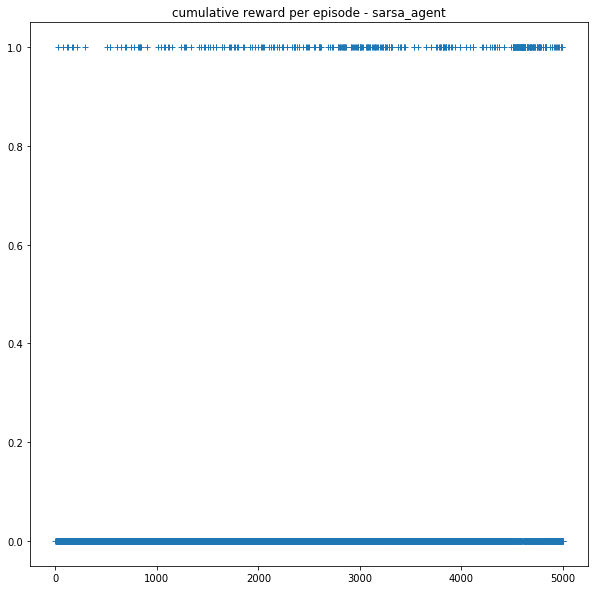

In [89]:
sarsa_agent = MySarsaAgent(env)
rewards = run_experiment_episode_train(env, sarsa_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - sarsa_agent')

In [90]:
sarsa_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

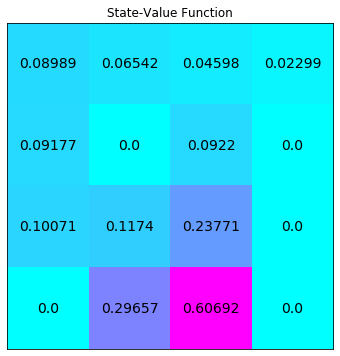

In [91]:
V = policy_evaluation(env, sarsa_agent.policy)
plot_values_lake(V)

In [92]:
V.sum()

1.7675613315114291

### Q-learning

Q learning is an offpolicy sarsa. Instead of update the Q function with the current policy action, it uses a greedy estimation of the policy action

SARAS $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma Q(S_{t+1},A_{t+1})−Q(S_t,A_t))$

Q-learning $Q(S_t,A_t) \leftarrow Q(S_t,A_t)+ \alpha(R_{t+1}+\gamma \max_a Q(S_{t+1},a)−Q(S_t,A_t))$

In [93]:
#TODO: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        pass #complete here
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

In [94]:
#Done: write Q learning update
class MyQAgent(Agent):
    def __init__(self, env, gamma = .99, epsilon = .1, alpha = .01):
        super().__init__(env, gamma, epsilon)
        self.alpha = alpha
        self.q = np.ones([self.env.observation_space.n, self.env.action_space.n]) / self.env.action_space.n
    def qsa_update(self, state, action, reward, next_state, done): 
        if done is False:
            target = reward + self.gamma * np.max(self.q[next_state, :])
        else:
            target = reward
        td_error = target - self.q[state, action]
        self.q[state, action]  += self.alpha * td_error
    def train(self, current_state, action, reward, next_state, done):
        self.qsa_update(current_state, action, reward, next_state, done)
        for state in range(env.observation_space.n):
            self.policy[state] = get_epsilon_greedy_policy(self.q[state], self.epsilon, env.action_space.n)

episode: 0 - cum reward 0.0
episode: 1 - cum reward 0.0
episode: 2 - cum reward 0.0
episode: 3 - cum reward 0.0
episode: 4 - cum reward 0.0
episode: 5 - cum reward 1.0
episode: 6 - cum reward 1.0
episode: 7 - cum reward 0.0
episode: 8 - cum reward 0.0
episode: 9 - cum reward 0.0
episode: 10 - cum reward 0.0
episode: 11 - cum reward 0.0
episode: 12 - cum reward 0.0
episode: 13 - cum reward 0.0
episode: 14 - cum reward 0.0
episode: 15 - cum reward 0.0
episode: 16 - cum reward 0.0
episode: 17 - cum reward 0.0
episode: 18 - cum reward 0.0
episode: 19 - cum reward 0.0
episode: 20 - cum reward 0.0
episode: 21 - cum reward 0.0
episode: 22 - cum reward 0.0
episode: 23 - cum reward 0.0
episode: 24 - cum reward 0.0
episode: 25 - cum reward 0.0
episode: 26 - cum reward 0.0
episode: 27 - cum reward 1.0
episode: 28 - cum reward 0.0
episode: 29 - cum reward 0.0
episode: 30 - cum reward 0.0
episode: 31 - cum reward 0.0
episode: 32 - cum reward 0.0
episode: 33 - cum reward 1.0
episode: 34 - cum reward

episode: 300 - cum reward 1.0
episode: 301 - cum reward 0.0
episode: 302 - cum reward 0.0
episode: 303 - cum reward 0.0
episode: 304 - cum reward 0.0
episode: 305 - cum reward 0.0
episode: 306 - cum reward 0.0
episode: 307 - cum reward 0.0
episode: 308 - cum reward 1.0
episode: 309 - cum reward 0.0
episode: 310 - cum reward 0.0
episode: 311 - cum reward 0.0
episode: 312 - cum reward 0.0
episode: 313 - cum reward 0.0
episode: 314 - cum reward 1.0
episode: 315 - cum reward 0.0
episode: 316 - cum reward 1.0
episode: 317 - cum reward 0.0
episode: 318 - cum reward 0.0
episode: 319 - cum reward 0.0
episode: 320 - cum reward 1.0
episode: 321 - cum reward 0.0
episode: 322 - cum reward 1.0
episode: 323 - cum reward 1.0
episode: 324 - cum reward 0.0
episode: 325 - cum reward 0.0
episode: 326 - cum reward 0.0
episode: 327 - cum reward 1.0
episode: 328 - cum reward 0.0
episode: 329 - cum reward 0.0
episode: 330 - cum reward 0.0
episode: 331 - cum reward 0.0
episode: 332 - cum reward 0.0
episode: 3

episode: 587 - cum reward 0.0
episode: 588 - cum reward 1.0
episode: 589 - cum reward 0.0
episode: 590 - cum reward 0.0
episode: 591 - cum reward 1.0
episode: 592 - cum reward 1.0
episode: 593 - cum reward 0.0
episode: 594 - cum reward 0.0
episode: 595 - cum reward 0.0
episode: 596 - cum reward 0.0
episode: 597 - cum reward 0.0
episode: 598 - cum reward 0.0
episode: 599 - cum reward 0.0
episode: 600 - cum reward 0.0
episode: 601 - cum reward 1.0
episode: 602 - cum reward 0.0
episode: 603 - cum reward 0.0
episode: 604 - cum reward 1.0
episode: 605 - cum reward 0.0
episode: 606 - cum reward 0.0
episode: 607 - cum reward 1.0
episode: 608 - cum reward 1.0
episode: 609 - cum reward 0.0
episode: 610 - cum reward 0.0
episode: 611 - cum reward 0.0
episode: 612 - cum reward 0.0
episode: 613 - cum reward 0.0
episode: 614 - cum reward 0.0
episode: 615 - cum reward 1.0
episode: 616 - cum reward 1.0
episode: 617 - cum reward 1.0
episode: 618 - cum reward 0.0
episode: 619 - cum reward 1.0
episode: 6

episode: 867 - cum reward 0.0
episode: 868 - cum reward 0.0
episode: 869 - cum reward 0.0
episode: 870 - cum reward 1.0
episode: 871 - cum reward 0.0
episode: 872 - cum reward 1.0
episode: 873 - cum reward 1.0
episode: 874 - cum reward 1.0
episode: 875 - cum reward 0.0
episode: 876 - cum reward 1.0
episode: 877 - cum reward 0.0
episode: 878 - cum reward 0.0
episode: 879 - cum reward 1.0
episode: 880 - cum reward 0.0
episode: 881 - cum reward 1.0
episode: 882 - cum reward 1.0
episode: 883 - cum reward 1.0
episode: 884 - cum reward 1.0
episode: 885 - cum reward 1.0
episode: 886 - cum reward 0.0
episode: 887 - cum reward 0.0
episode: 888 - cum reward 0.0
episode: 889 - cum reward 1.0
episode: 890 - cum reward 0.0
episode: 891 - cum reward 0.0
episode: 892 - cum reward 0.0
episode: 893 - cum reward 1.0
episode: 894 - cum reward 1.0
episode: 895 - cum reward 1.0
episode: 896 - cum reward 1.0
episode: 897 - cum reward 1.0
episode: 898 - cum reward 0.0
episode: 899 - cum reward 0.0
episode: 9

episode: 1152 - cum reward 0.0
episode: 1153 - cum reward 0.0
episode: 1154 - cum reward 1.0
episode: 1155 - cum reward 1.0
episode: 1156 - cum reward 1.0
episode: 1157 - cum reward 0.0
episode: 1158 - cum reward 1.0
episode: 1159 - cum reward 0.0
episode: 1160 - cum reward 0.0
episode: 1161 - cum reward 1.0
episode: 1162 - cum reward 0.0
episode: 1163 - cum reward 1.0
episode: 1164 - cum reward 1.0
episode: 1165 - cum reward 1.0
episode: 1166 - cum reward 1.0
episode: 1167 - cum reward 0.0
episode: 1168 - cum reward 1.0
episode: 1169 - cum reward 0.0
episode: 1170 - cum reward 0.0
episode: 1171 - cum reward 0.0
episode: 1172 - cum reward 1.0
episode: 1173 - cum reward 0.0
episode: 1174 - cum reward 0.0
episode: 1175 - cum reward 0.0
episode: 1176 - cum reward 0.0
episode: 1177 - cum reward 1.0
episode: 1178 - cum reward 0.0
episode: 1179 - cum reward 0.0
episode: 1180 - cum reward 1.0
episode: 1181 - cum reward 1.0
episode: 1182 - cum reward 1.0
episode: 1183 - cum reward 0.0
episode:

episode: 1426 - cum reward 1.0
episode: 1427 - cum reward 1.0
episode: 1428 - cum reward 1.0
episode: 1429 - cum reward 0.0
episode: 1430 - cum reward 1.0
episode: 1431 - cum reward 0.0
episode: 1432 - cum reward 0.0
episode: 1433 - cum reward 0.0
episode: 1434 - cum reward 1.0
episode: 1435 - cum reward 0.0
episode: 1436 - cum reward 0.0
episode: 1437 - cum reward 0.0
episode: 1438 - cum reward 1.0
episode: 1439 - cum reward 1.0
episode: 1440 - cum reward 0.0
episode: 1441 - cum reward 1.0
episode: 1442 - cum reward 0.0
episode: 1443 - cum reward 1.0
episode: 1444 - cum reward 1.0
episode: 1445 - cum reward 0.0
episode: 1446 - cum reward 0.0
episode: 1447 - cum reward 0.0
episode: 1448 - cum reward 0.0
episode: 1449 - cum reward 1.0
episode: 1450 - cum reward 0.0
episode: 1451 - cum reward 0.0
episode: 1452 - cum reward 0.0
episode: 1453 - cum reward 1.0
episode: 1454 - cum reward 0.0
episode: 1455 - cum reward 1.0
episode: 1456 - cum reward 0.0
episode: 1457 - cum reward 0.0
episode:

episode: 1724 - cum reward 0.0
episode: 1725 - cum reward 1.0
episode: 1726 - cum reward 0.0
episode: 1727 - cum reward 0.0
episode: 1728 - cum reward 0.0
episode: 1729 - cum reward 1.0
episode: 1730 - cum reward 0.0
episode: 1731 - cum reward 0.0
episode: 1732 - cum reward 0.0
episode: 1733 - cum reward 1.0
episode: 1734 - cum reward 0.0
episode: 1735 - cum reward 0.0
episode: 1736 - cum reward 1.0
episode: 1737 - cum reward 0.0
episode: 1738 - cum reward 0.0
episode: 1739 - cum reward 1.0
episode: 1740 - cum reward 1.0
episode: 1741 - cum reward 1.0
episode: 1742 - cum reward 0.0
episode: 1743 - cum reward 0.0
episode: 1744 - cum reward 1.0
episode: 1745 - cum reward 1.0
episode: 1746 - cum reward 0.0
episode: 1747 - cum reward 1.0
episode: 1748 - cum reward 0.0
episode: 1749 - cum reward 0.0
episode: 1750 - cum reward 0.0
episode: 1751 - cum reward 1.0
episode: 1752 - cum reward 0.0
episode: 1753 - cum reward 1.0
episode: 1754 - cum reward 1.0
episode: 1755 - cum reward 0.0
episode:

episode: 1997 - cum reward 0.0
episode: 1998 - cum reward 0.0
episode: 1999 - cum reward 1.0
episode: 2000 - cum reward 0.0
episode: 2001 - cum reward 0.0
episode: 2002 - cum reward 0.0
episode: 2003 - cum reward 1.0
episode: 2004 - cum reward 0.0
episode: 2005 - cum reward 1.0
episode: 2006 - cum reward 1.0
episode: 2007 - cum reward 1.0
episode: 2008 - cum reward 0.0
episode: 2009 - cum reward 0.0
episode: 2010 - cum reward 0.0
episode: 2011 - cum reward 1.0
episode: 2012 - cum reward 0.0
episode: 2013 - cum reward 0.0
episode: 2014 - cum reward 0.0
episode: 2015 - cum reward 1.0
episode: 2016 - cum reward 0.0
episode: 2017 - cum reward 0.0
episode: 2018 - cum reward 0.0
episode: 2019 - cum reward 1.0
episode: 2020 - cum reward 0.0
episode: 2021 - cum reward 0.0
episode: 2022 - cum reward 1.0
episode: 2023 - cum reward 1.0
episode: 2024 - cum reward 1.0
episode: 2025 - cum reward 1.0
episode: 2026 - cum reward 1.0
episode: 2027 - cum reward 1.0
episode: 2028 - cum reward 0.0
episode:

episode: 2292 - cum reward 0.0
episode: 2293 - cum reward 0.0
episode: 2294 - cum reward 0.0
episode: 2295 - cum reward 0.0
episode: 2296 - cum reward 0.0
episode: 2297 - cum reward 0.0
episode: 2298 - cum reward 1.0
episode: 2299 - cum reward 1.0
episode: 2300 - cum reward 1.0
episode: 2301 - cum reward 0.0
episode: 2302 - cum reward 1.0
episode: 2303 - cum reward 0.0
episode: 2304 - cum reward 0.0
episode: 2305 - cum reward 0.0
episode: 2306 - cum reward 0.0
episode: 2307 - cum reward 0.0
episode: 2308 - cum reward 1.0
episode: 2309 - cum reward 0.0
episode: 2310 - cum reward 0.0
episode: 2311 - cum reward 0.0
episode: 2312 - cum reward 0.0
episode: 2313 - cum reward 0.0
episode: 2314 - cum reward 1.0
episode: 2315 - cum reward 1.0
episode: 2316 - cum reward 1.0
episode: 2317 - cum reward 0.0
episode: 2318 - cum reward 0.0
episode: 2319 - cum reward 0.0
episode: 2320 - cum reward 1.0
episode: 2321 - cum reward 1.0
episode: 2322 - cum reward 0.0
episode: 2323 - cum reward 1.0
episode:

episode: 2579 - cum reward 0.0
episode: 2580 - cum reward 0.0
episode: 2581 - cum reward 0.0
episode: 2582 - cum reward 0.0
episode: 2583 - cum reward 0.0
episode: 2584 - cum reward 0.0
episode: 2585 - cum reward 0.0
episode: 2586 - cum reward 0.0
episode: 2587 - cum reward 0.0
episode: 2588 - cum reward 0.0
episode: 2589 - cum reward 0.0
episode: 2590 - cum reward 1.0
episode: 2591 - cum reward 0.0
episode: 2592 - cum reward 1.0
episode: 2593 - cum reward 1.0
episode: 2594 - cum reward 1.0
episode: 2595 - cum reward 0.0
episode: 2596 - cum reward 1.0
episode: 2597 - cum reward 1.0
episode: 2598 - cum reward 1.0
episode: 2599 - cum reward 1.0
episode: 2600 - cum reward 0.0
episode: 2601 - cum reward 1.0
episode: 2602 - cum reward 0.0
episode: 2603 - cum reward 1.0
episode: 2604 - cum reward 1.0
episode: 2605 - cum reward 1.0
episode: 2606 - cum reward 0.0
episode: 2607 - cum reward 0.0
episode: 2608 - cum reward 0.0
episode: 2609 - cum reward 0.0
episode: 2610 - cum reward 0.0
episode:

episode: 2851 - cum reward 1.0
episode: 2852 - cum reward 0.0
episode: 2853 - cum reward 0.0
episode: 2854 - cum reward 1.0
episode: 2855 - cum reward 1.0
episode: 2856 - cum reward 1.0
episode: 2857 - cum reward 0.0
episode: 2858 - cum reward 1.0
episode: 2859 - cum reward 0.0
episode: 2860 - cum reward 1.0
episode: 2861 - cum reward 0.0
episode: 2862 - cum reward 0.0
episode: 2863 - cum reward 0.0
episode: 2864 - cum reward 1.0
episode: 2865 - cum reward 1.0
episode: 2866 - cum reward 1.0
episode: 2867 - cum reward 1.0
episode: 2868 - cum reward 1.0
episode: 2869 - cum reward 0.0
episode: 2870 - cum reward 0.0
episode: 2871 - cum reward 0.0
episode: 2872 - cum reward 0.0
episode: 2873 - cum reward 0.0
episode: 2874 - cum reward 1.0
episode: 2875 - cum reward 1.0
episode: 2876 - cum reward 1.0
episode: 2877 - cum reward 1.0
episode: 2878 - cum reward 1.0
episode: 2879 - cum reward 1.0
episode: 2880 - cum reward 1.0
episode: 2881 - cum reward 0.0
episode: 2882 - cum reward 1.0
episode:

episode: 3137 - cum reward 0.0
episode: 3138 - cum reward 0.0
episode: 3139 - cum reward 1.0
episode: 3140 - cum reward 0.0
episode: 3141 - cum reward 0.0
episode: 3142 - cum reward 1.0
episode: 3143 - cum reward 0.0
episode: 3144 - cum reward 0.0
episode: 3145 - cum reward 0.0
episode: 3146 - cum reward 0.0
episode: 3147 - cum reward 0.0
episode: 3148 - cum reward 0.0
episode: 3149 - cum reward 0.0
episode: 3150 - cum reward 1.0
episode: 3151 - cum reward 0.0
episode: 3152 - cum reward 1.0
episode: 3153 - cum reward 1.0
episode: 3154 - cum reward 0.0
episode: 3155 - cum reward 1.0
episode: 3156 - cum reward 0.0
episode: 3157 - cum reward 0.0
episode: 3158 - cum reward 0.0
episode: 3159 - cum reward 1.0
episode: 3160 - cum reward 1.0
episode: 3161 - cum reward 1.0
episode: 3162 - cum reward 0.0
episode: 3163 - cum reward 1.0
episode: 3164 - cum reward 1.0
episode: 3165 - cum reward 0.0
episode: 3166 - cum reward 0.0
episode: 3167 - cum reward 1.0
episode: 3168 - cum reward 0.0
episode:

episode: 3402 - cum reward 0.0
episode: 3403 - cum reward 0.0
episode: 3404 - cum reward 0.0
episode: 3405 - cum reward 0.0
episode: 3406 - cum reward 0.0
episode: 3407 - cum reward 1.0
episode: 3408 - cum reward 1.0
episode: 3409 - cum reward 0.0
episode: 3410 - cum reward 0.0
episode: 3411 - cum reward 1.0
episode: 3412 - cum reward 0.0
episode: 3413 - cum reward 1.0
episode: 3414 - cum reward 0.0
episode: 3415 - cum reward 0.0
episode: 3416 - cum reward 1.0
episode: 3417 - cum reward 1.0
episode: 3418 - cum reward 1.0
episode: 3419 - cum reward 0.0
episode: 3420 - cum reward 1.0
episode: 3421 - cum reward 1.0
episode: 3422 - cum reward 0.0
episode: 3423 - cum reward 0.0
episode: 3424 - cum reward 1.0
episode: 3425 - cum reward 0.0
episode: 3426 - cum reward 0.0
episode: 3427 - cum reward 0.0
episode: 3428 - cum reward 1.0
episode: 3429 - cum reward 0.0
episode: 3430 - cum reward 1.0
episode: 3431 - cum reward 0.0
episode: 3432 - cum reward 0.0
episode: 3433 - cum reward 1.0
episode:

episode: 3670 - cum reward 1.0
episode: 3671 - cum reward 0.0
episode: 3672 - cum reward 1.0
episode: 3673 - cum reward 0.0
episode: 3674 - cum reward 1.0
episode: 3675 - cum reward 1.0
episode: 3676 - cum reward 1.0
episode: 3677 - cum reward 0.0
episode: 3678 - cum reward 0.0
episode: 3679 - cum reward 0.0
episode: 3680 - cum reward 0.0
episode: 3681 - cum reward 1.0
episode: 3682 - cum reward 1.0
episode: 3683 - cum reward 1.0
episode: 3684 - cum reward 0.0
episode: 3685 - cum reward 1.0
episode: 3686 - cum reward 0.0
episode: 3687 - cum reward 0.0
episode: 3688 - cum reward 1.0
episode: 3689 - cum reward 0.0
episode: 3690 - cum reward 0.0
episode: 3691 - cum reward 0.0
episode: 3692 - cum reward 1.0
episode: 3693 - cum reward 0.0
episode: 3694 - cum reward 1.0
episode: 3695 - cum reward 1.0
episode: 3696 - cum reward 0.0
episode: 3697 - cum reward 0.0
episode: 3698 - cum reward 0.0
episode: 3699 - cum reward 0.0
episode: 3700 - cum reward 0.0
episode: 3701 - cum reward 1.0
episode:

episode: 3967 - cum reward 0.0
episode: 3968 - cum reward 0.0
episode: 3969 - cum reward 0.0
episode: 3970 - cum reward 0.0
episode: 3971 - cum reward 1.0
episode: 3972 - cum reward 0.0
episode: 3973 - cum reward 0.0
episode: 3974 - cum reward 0.0
episode: 3975 - cum reward 0.0
episode: 3976 - cum reward 0.0
episode: 3977 - cum reward 1.0
episode: 3978 - cum reward 0.0
episode: 3979 - cum reward 1.0
episode: 3980 - cum reward 1.0
episode: 3981 - cum reward 0.0
episode: 3982 - cum reward 0.0
episode: 3983 - cum reward 1.0
episode: 3984 - cum reward 1.0
episode: 3985 - cum reward 1.0
episode: 3986 - cum reward 0.0
episode: 3987 - cum reward 0.0
episode: 3988 - cum reward 1.0
episode: 3989 - cum reward 1.0
episode: 3990 - cum reward 0.0
episode: 3991 - cum reward 1.0
episode: 3992 - cum reward 1.0
episode: 3993 - cum reward 0.0
episode: 3994 - cum reward 0.0
episode: 3995 - cum reward 1.0
episode: 3996 - cum reward 0.0
episode: 3997 - cum reward 0.0
episode: 3998 - cum reward 1.0
episode:

episode: 4271 - cum reward 0.0
episode: 4272 - cum reward 0.0
episode: 4273 - cum reward 1.0
episode: 4274 - cum reward 0.0
episode: 4275 - cum reward 1.0
episode: 4276 - cum reward 1.0
episode: 4277 - cum reward 0.0
episode: 4278 - cum reward 1.0
episode: 4279 - cum reward 0.0
episode: 4280 - cum reward 0.0
episode: 4281 - cum reward 0.0
episode: 4282 - cum reward 1.0
episode: 4283 - cum reward 0.0
episode: 4284 - cum reward 1.0
episode: 4285 - cum reward 0.0
episode: 4286 - cum reward 0.0
episode: 4287 - cum reward 1.0
episode: 4288 - cum reward 1.0
episode: 4289 - cum reward 0.0
episode: 4290 - cum reward 0.0
episode: 4291 - cum reward 0.0
episode: 4292 - cum reward 0.0
episode: 4293 - cum reward 1.0
episode: 4294 - cum reward 0.0
episode: 4295 - cum reward 0.0
episode: 4296 - cum reward 1.0
episode: 4297 - cum reward 0.0
episode: 4298 - cum reward 1.0
episode: 4299 - cum reward 0.0
episode: 4300 - cum reward 0.0
episode: 4301 - cum reward 0.0
episode: 4302 - cum reward 1.0
episode:

episode: 4555 - cum reward 1.0
episode: 4556 - cum reward 0.0
episode: 4557 - cum reward 1.0
episode: 4558 - cum reward 0.0
episode: 4559 - cum reward 0.0
episode: 4560 - cum reward 0.0
episode: 4561 - cum reward 1.0
episode: 4562 - cum reward 0.0
episode: 4563 - cum reward 0.0
episode: 4564 - cum reward 0.0
episode: 4565 - cum reward 1.0
episode: 4566 - cum reward 0.0
episode: 4567 - cum reward 1.0
episode: 4568 - cum reward 0.0
episode: 4569 - cum reward 0.0
episode: 4570 - cum reward 0.0
episode: 4571 - cum reward 0.0
episode: 4572 - cum reward 1.0
episode: 4573 - cum reward 0.0
episode: 4574 - cum reward 0.0
episode: 4575 - cum reward 0.0
episode: 4576 - cum reward 0.0
episode: 4577 - cum reward 0.0
episode: 4578 - cum reward 0.0
episode: 4579 - cum reward 0.0
episode: 4580 - cum reward 0.0
episode: 4581 - cum reward 1.0
episode: 4582 - cum reward 0.0
episode: 4583 - cum reward 0.0
episode: 4584 - cum reward 0.0
episode: 4585 - cum reward 1.0
episode: 4586 - cum reward 1.0
episode:

episode: 4860 - cum reward 0.0
episode: 4861 - cum reward 1.0
episode: 4862 - cum reward 1.0
episode: 4863 - cum reward 0.0
episode: 4864 - cum reward 0.0
episode: 4865 - cum reward 0.0
episode: 4866 - cum reward 0.0
episode: 4867 - cum reward 0.0
episode: 4868 - cum reward 0.0
episode: 4869 - cum reward 0.0
episode: 4870 - cum reward 0.0
episode: 4871 - cum reward 0.0
episode: 4872 - cum reward 0.0
episode: 4873 - cum reward 0.0
episode: 4874 - cum reward 0.0
episode: 4875 - cum reward 0.0
episode: 4876 - cum reward 1.0
episode: 4877 - cum reward 1.0
episode: 4878 - cum reward 0.0
episode: 4879 - cum reward 1.0
episode: 4880 - cum reward 1.0
episode: 4881 - cum reward 0.0
episode: 4882 - cum reward 1.0
episode: 4883 - cum reward 1.0
episode: 4884 - cum reward 0.0
episode: 4885 - cum reward 1.0
episode: 4886 - cum reward 1.0
episode: 4887 - cum reward 0.0
episode: 4888 - cum reward 1.0
episode: 4889 - cum reward 1.0
episode: 4890 - cum reward 0.0
episode: 4891 - cum reward 0.0
episode:

Text(0.5, 1.0, 'cumulative reward per episode - q_agent')

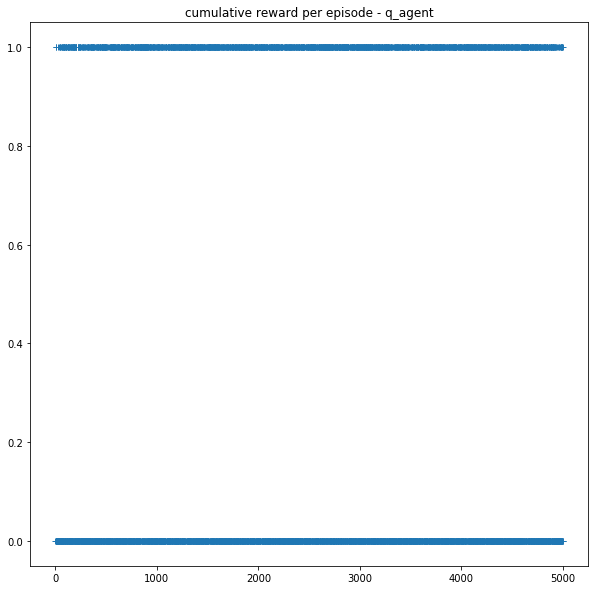

In [95]:
q_agent = MyQAgent(env)
rewards = run_experiment_episode_train(env, q_agent, 5000)
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(rewards,'+')
ax.set_title('cumulative reward per episode - q_agent')

In [96]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

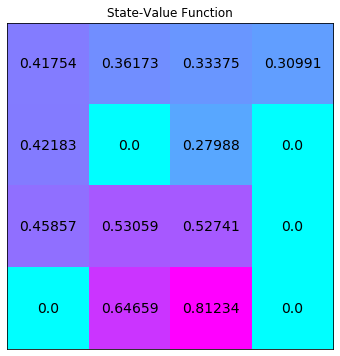

In [97]:
V = policy_evaluation(env, q_agent.policy)
plot_values_lake(V)

In [98]:
V.sum()

5.100116629064201

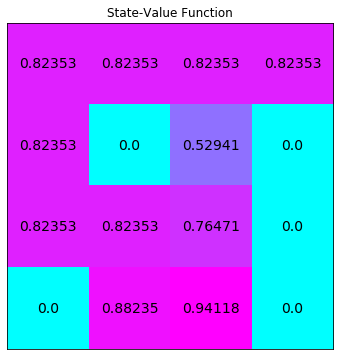

8.882351322605881

In [99]:
policy_best, V_best = value_iteration(env)
plot_values_lake(V_best)
V_best.sum()

In [100]:
#Question: Why we don't have the optimal policy?

In [103]:
q_agent.policy

array([[0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.025, 0.025, 0.925],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.025, 0.925],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025],
       [0.025, 0.025, 0.925, 0.025],
       [0.025, 0.925, 0.025, 0.025],
       [0.925, 0.025, 0.025, 0.025]])

In [101]:
q_policy_no_eps = np.zeros(q_agent.policy.shape)
q_policy_no_eps[np.arange(len(q_policy_no_eps)), q_agent.policy.argmax(axis=1)] = 1

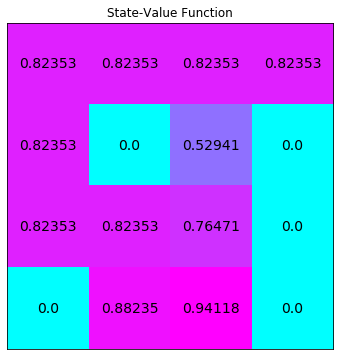

8.882351322605881

In [102]:
V = policy_evaluation(env, q_policy_no_eps)
plot_values_lake(V)
V_best.sum()

In [104]:
q_policy_no_eps

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

### keep in mind:
\begin{aligned}
MDP \rightarrow V(S_t) &\leftarrow \mathbb{E}[R_{t+1} + \gamma V(S_{t+1})] \\
MC \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (G_t - V(S_{t+1})\\
TD \rightarrow V(S_t) &\leftarrow V(S_t) + \alpha (R_{t+1} + \gamma V(S_{t+1}) - V(S_t))
\end{aligned}